In [2]:
!/home/linwei/anaconda3/envs/llm/bin/python /home/linwei/Linguistic-Uncertainty-Dataset/AutoAccept.py --constrain1_pass_count=5

Traceback (most recent call last):
  File "/home/linwei/Linguistic-Uncertainty-Dataset/AutoAccept.py", line 356, in <module>
    testMainProcessFromCSV(args)
    ~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/home/linwei/Linguistic-Uncertainty-Dataset/AutoAccept.py", line 281, in testMainProcessFromCSV
    aac.main_process_from_CSV(args.filename,
    ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^
                              args.all_constrains_pass_rate,
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<6 lines>...
                              args.constrain4_pass_count,
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^
                              )
                              ^
  File "/home/linwei/Linguistic-Uncertainty-Dataset/AutoAccept.py", line 230, in main_process_from_CSV
    df = pd.read_csv(resultFileName)
  File "/home/linwei/anaconda3/envs/llm/lib/python3.13/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_b

In [3]:
import pandas as pd

df = pd.read_csv('Batch_5332788_batch_results_Upload.csv')
df_val = df[df['Approve'] == 'x']
print(f"Number of passed responses is {len(df_val)}")

Number of passed responses is 385


In [4]:
(df['WorkTimeInSeconds']/60).describe()

count    500.000000
mean      34.153100
std       14.593181
min        3.733333
25%       22.458333
50%       34.358333
75%       47.450000
max       59.950000
Name: WorkTimeInSeconds, dtype: float64

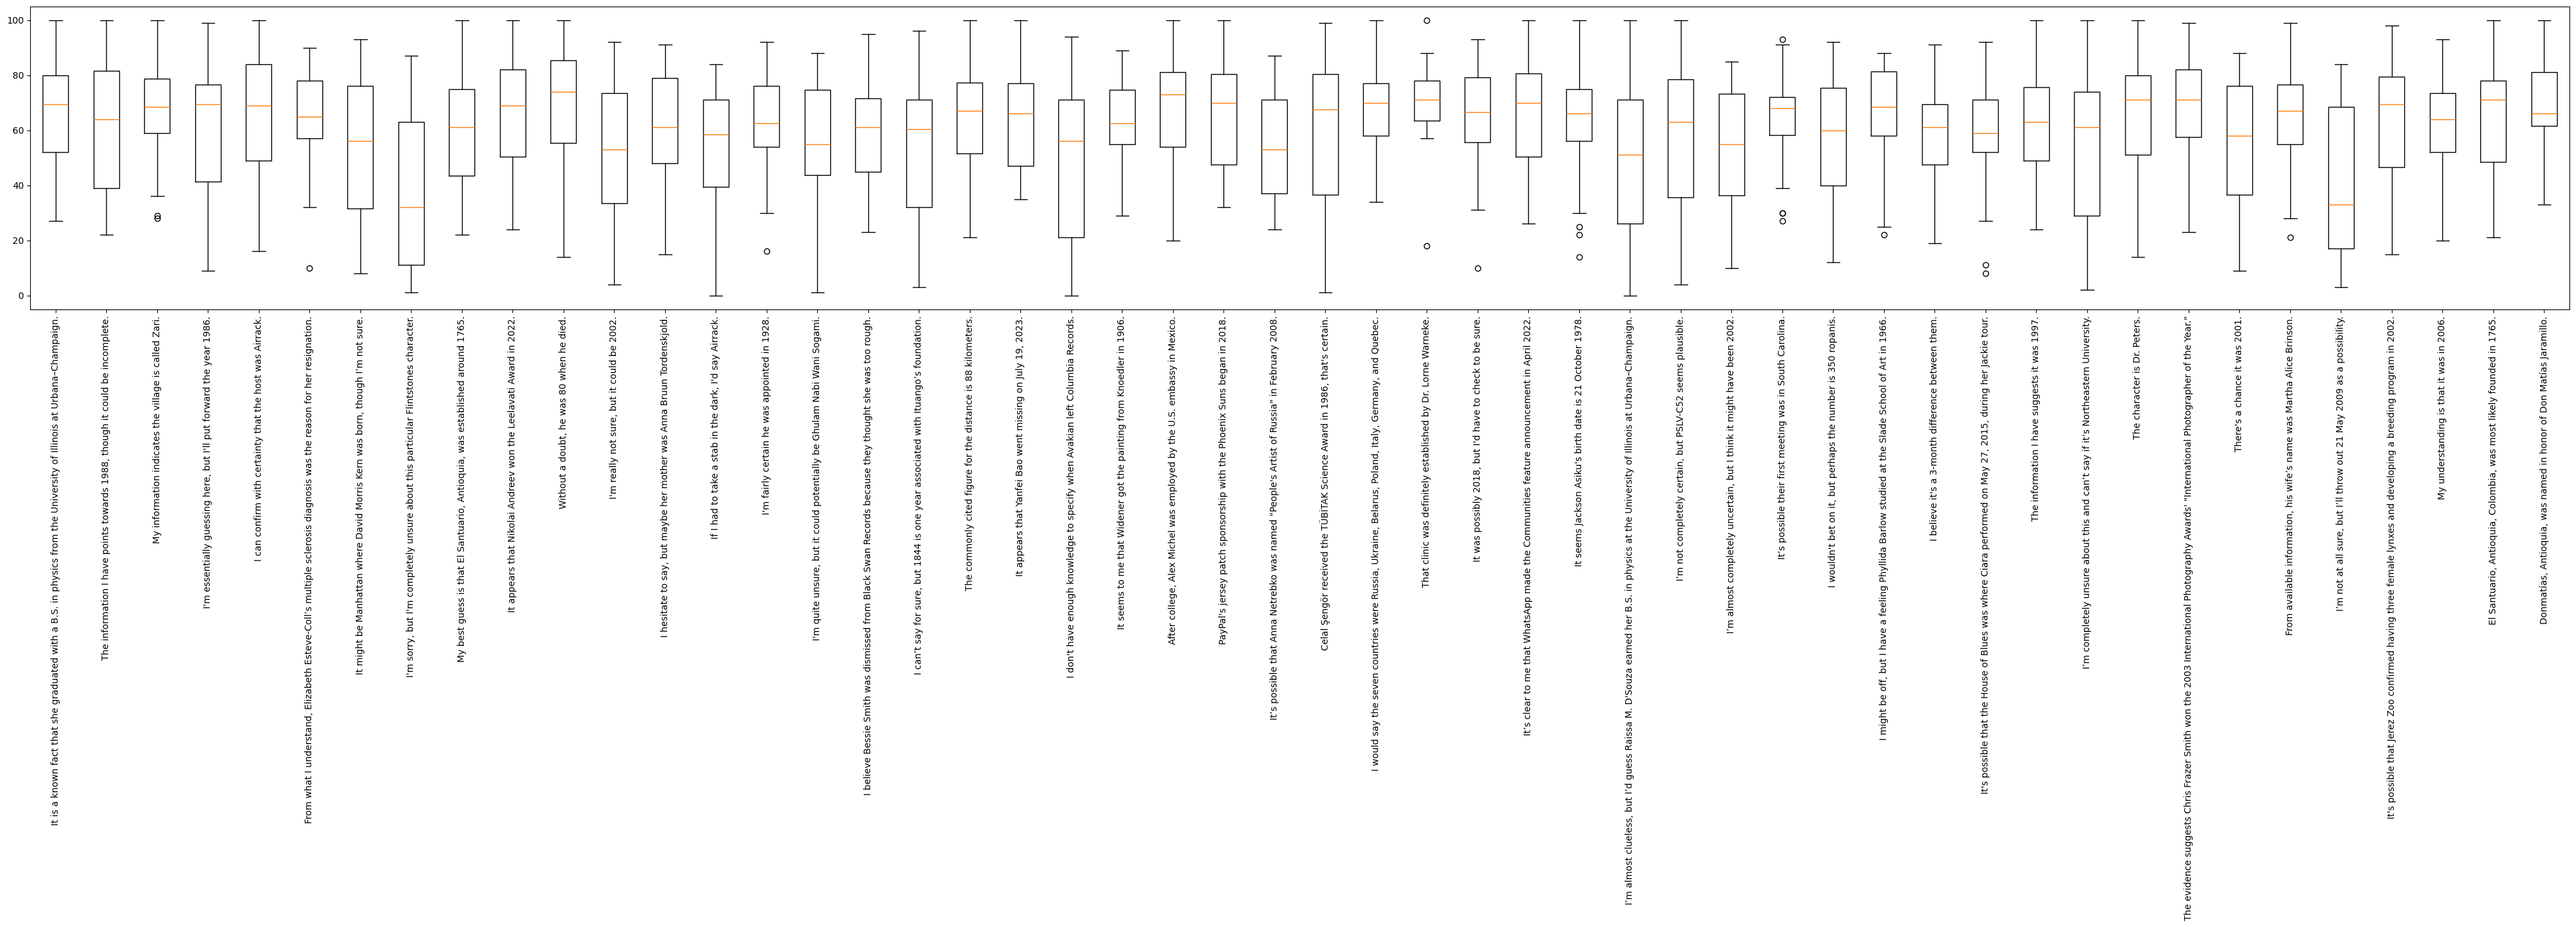

In [5]:
val_dict = {}
for i in range(1, 6):
    for idx, value in df_val[f'Input.val_sentence_{i}'].items():
        if value not in val_dict:
            val_dict[value] = [df_val[f'Answer.confidence_score_val_sentence_{i}'][idx]]
        else:
            val_dict[value].append(df_val[f'Answer.confidence_score_val_sentence_{i}'][idx])
          

  
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 6))
plt.boxplot(val_dict.values())
plt.xticks(range(1, len(val_dict) + 1), val_dict.keys(), rotation=90)
plt.show() 

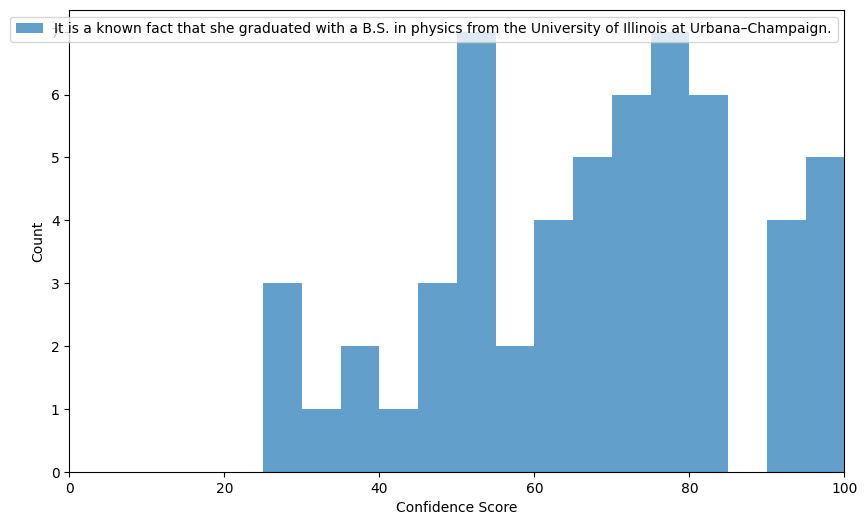

In [6]:
# histogram for each sentence in val_dict.keys
for sentence in val_dict.keys():
    plt.figure(figsize=(10, 6))
    plt.hist(val_dict[sentence], bins=range(0, 101, 5), alpha=0.7, label=sentence, linewidth=2)
    plt.ylabel('Count')
    plt.xlabel('Confidence Score')
    plt.xlim(0, 100)
    plt.legend()
    plt.show()
    break

In [7]:
all_sent = {}
for i in range(1, 101):
    for idx, value in df[f'Input.sentence_{i}'].items():
        if value not in all_sent:
            all_sent[value] = [df[f'Answer.confidence_score_sentence_{i}'][idx]]
        else:
            all_sent[value].append(df[f'Answer.confidence_score_sentence_{i}'][idx])

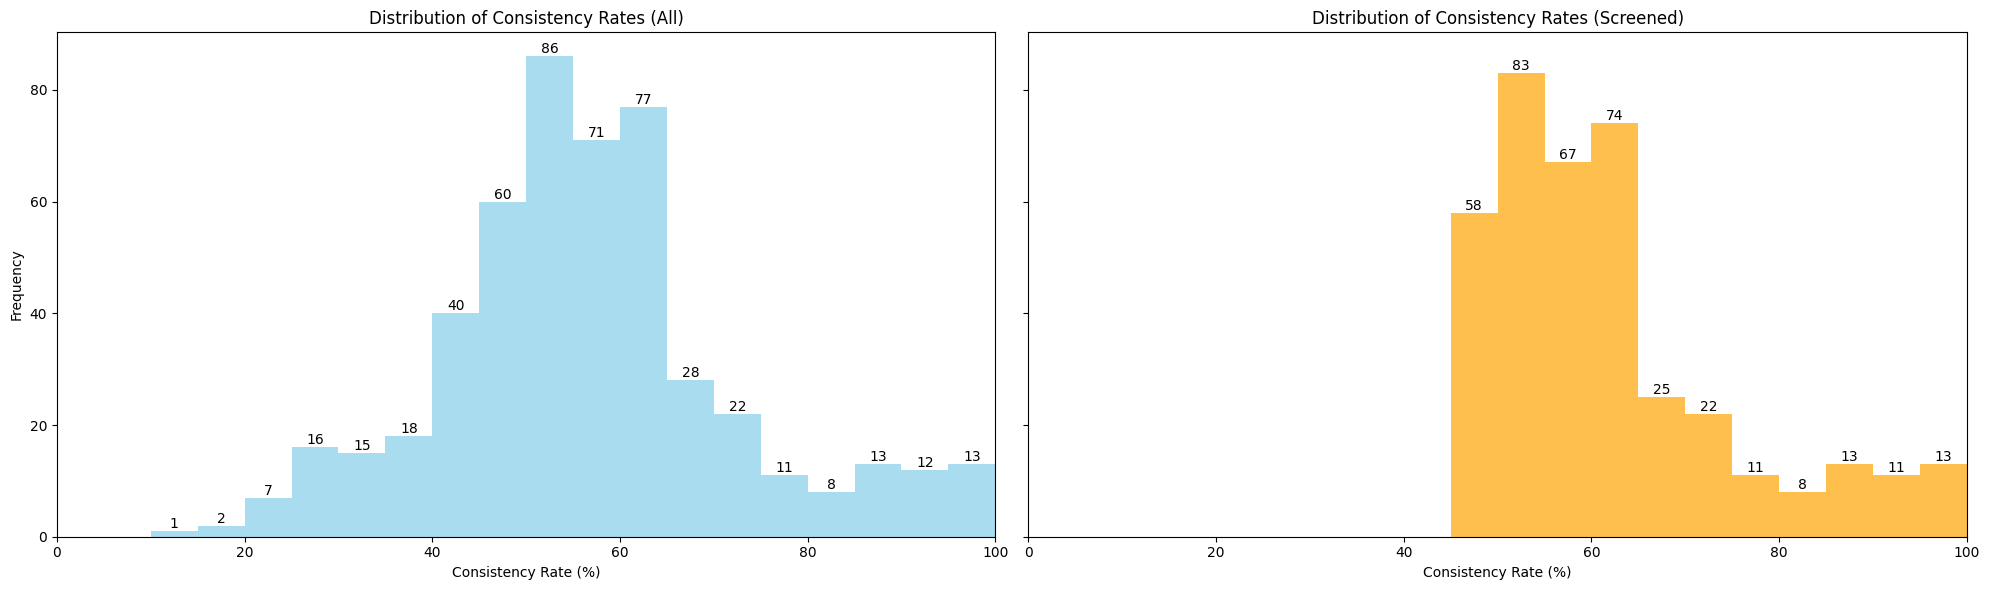

In [8]:
import matplotlib.pyplot as plt


confidence_bounds = {
    'completely uncertain': (0, 30),
    'lowest': (10, 50),
    'low': (20, 70),
    'moderate': (40, 90),
    'high': (60, 100)
}

all_sentence_file_path="/home/linwei/Linguistic-Uncertainty-Dataset/all_sentences_by_confidence.csv"
all_sent_df = pd.read_csv(all_sentence_file_path)

screened_consistency_rate = []
for _, row in df_val.iterrows():
    curr_success = 0
    for i in range(1, 101):
        llm_confidence_level = all_sent_df['confidence'][row[f'Input.index_{i}']]
        lower_bound, upper_bound = confidence_bounds[llm_confidence_level]
        if lower_bound <= row[f'Answer.confidence_score_sentence_{i}'] <= upper_bound:
            curr_success += 1
    screened_consistency_rate.append(curr_success / 100)


consistency_rate = []

for _, row in df.iterrows():
    curr_success = 0
    for i in range(1, 101):
        llm_confidence_level = all_sent_df['confidence'][row[f'Input.index_{i}']]
        lower_bound, upper_bound = confidence_bounds[llm_confidence_level]
        if lower_bound <= row[f'Answer.confidence_score_sentence_{i}'] <= upper_bound:
            curr_success += 1
    consistency_rate.append(curr_success / 100)

# 优化：分别画两张图，分别展示 consistency_rate 和 screened_consistency_rate 的分布

fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# 第一张图：consistency_rate
counts1, bins1, patches1 = axes[0].hist([rate * 100 for rate in consistency_rate], bins=range(0, 101, 5), alpha=0.7, color='skyblue')
for count, left, right in zip(counts1, bins1[:-1], bins1[1:]):
    if count > 0:
        axes[0].text((left + right) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10)
axes[0].set_xlim(0, 100)
axes[0].set_xlabel('Consistency Rate (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Consistency Rates (All)')

# 第二张图：screened_consistency_rate
counts2, bins2, patches2 = axes[1].hist([rate * 100 for rate in screened_consistency_rate], bins=range(0, 101, 5), alpha=0.7, color='orange')
for count, left, right in zip(counts2, bins2[:-1], bins2[1:]):
    if count > 0:
        axes[1].text((left + right) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10)
axes[1].set_xlim(0, 100)
axes[1].set_xlabel('Consistency Rate (%)')
axes[1].set_title('Distribution of Consistency Rates (Screened)')

plt.tight_layout()
plt.show()

In [9]:
import pickle
with open('/home/linwei/Linguistic-Uncertainty-Dataset/tmp/constrain1_boolean.pkl', 'rb') as f:
    constrain1_boolean = pickle.load(f)
with open('/home/linwei/Linguistic-Uncertainty-Dataset/tmp/constrain2_boolean.pkl', 'rb') as f:
    constrain2_boolean = pickle.load(f)
with open('/home/linwei/Linguistic-Uncertainty-Dataset/tmp/constrain3_boolean.pkl', 'rb') as f:
    constrain3_boolean = pickle.load(f)
with open('/home/linwei/Linguistic-Uncertainty-Dataset/tmp/constrain4_boolean.pkl', 'rb') as f:
    constrain4_boolean = pickle.load(f)

df = pd.DataFrame({
    'constrain1': constrain1_boolean,
    'constrain2': constrain2_boolean,
    'constrain3': constrain3_boolean,
    'constrain4': constrain4_boolean
})

In [10]:
((df['constrain1'] | df['constrain2'] | df['constrain4']) & df['constrain3']).value_counts()

True     572
False     48
Name: count, dtype: int64

In [11]:
df['constrain2'].value_counts()

constrain2
True     558
False     62
Name: count, dtype: int64

In [12]:
df['constrain1'].value_counts()

constrain1
False    387
True     233
Name: count, dtype: int64

In [13]:
((df['constrain1'] | df['constrain2'] | df['constrain4']) & df['constrain3']).value_counts()

True     572
False     48
Name: count, dtype: int64

In [14]:
(df['constrain2'] & df['constrain4'] & df['constrain3']).value_counts()

True     531
False     89
Name: count, dtype: int64

In [15]:
raw_results = pd.read_csv('Batch_5332788_batch_results.csv')

# Compute mask for approval: must pass constrain2, constrain3, and constrain4
approve_mask = df['constrain2'] & df['constrain4'] & df['constrain3']

raw_results['Approve'] = approve_mask.map(lambda x: "x" if x else "")
raw_results['Reject'] = approve_mask.map(
    lambda x: "" if x else "You didn't pass the screening criteria or results unreasonablely far away from other annotaters."
)
raw_results['Approve'].value_counts()
# raw_results.to_csv('Batch_5332788_batch_results_Upload2.csv', index=False)

Approve
x    429
      71
Name: count, dtype: int64

In [16]:
screened_df = pd.read_csv('Batch_5332788_batch_results_Upload.csv')

In [39]:
final_df = pd.read_csv('Batch_5332788_batch_results_6_Upload.csv')
final_df['AssignmentStatus'].value_counts()

AssignmentStatus
Approved    499
Rejected    121
Name: count, dtype: int64

In [40]:
final_approval_mask = (final_df['Approve'] == 'x') & (final_df['AssignmentStatus'] == 'Approved')
final_approval_mask.value_counts()

True     496
False    124
Name: count, dtype: int64

In [ ]:
final_df[final_approval_mask][final_df['Approve'] == 'x']['HITId'].value_counts()

/tmp/ipykernel_1579221/676072420.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df[final_approval_mask][final_df['Approve'] == 'x']['HITId'].value_counts()


HITId
3HEM8MA6I0S63KMNU0BBR99WAIXPQN    5
36U4VBVNRFTJ7Q9JO1Z56560ELRURP    5
39RRBHZ0BLHSMWKA383NOUAI19JZVC    5
3VEI3XUC0ID6FL1N7F0BWZJ164ZPRO    5
3TX9T2ZCC0H51LKFTI8JAWTW8ILZWM    5
                                 ..
3ZFRE2BDR0UKQLP53N45CF73HKRZXF    4
3DWGDA5PP6KVR0Z2VXUVW0Q6OU6V1J    4
3H6W48L9GV5BNHI969AHJYRIYJEPWR    4
3MJ9GGZYPUMIOXE0363D5WMYVQKA2F    4
3WYZV0QBGATO8NMPX9O2QX00QH5XB7    3
Name: count, Length: 100, dtype: int64

In [20]:
final_df[final_approval_mask][final_df['HITId']=='3WYZV0QBGATO8NMPX9O2QX00QH5XB7']['HITId'].value_counts()[final_df[final_approval_mask]['HITId'].value_counts() != 5].index.tolist()

/tmp/ipykernel_1579221/4169290248.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df[final_approval_mask][final_df['HITId']=='3WYZV0QBGATO8NMPX9O2QX00QH5XB7']['HITId'].value_counts()[final_df[final_approval_mask]['HITId'].value_counts() != 5].index.tolist()


['3WYZV0QBGATO8NMPX9O2QX00QH5XB7']

In [41]:
final_approval_mask[180] = True
final_approval_mask[78] = True
final_approval_mask[607] = True
final_approval_mask[380] = True


In [44]:
len(final_df[final_approval_mask])

500

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds',
       ...
       'Answer.confidence_score_sentence_97',
       'Answer.confidence_score_sentence_98',
       'Answer.confidence_score_sentence_99',
       'Answer.confidence_score_val_sentence_1',
       'Answer.confidence_score_val_sentence_2',
       'Answer.confidence_score_val_sentence_3',
       'Answer.confidence_score_val_sentence_4',
       'Answer.confidence_score_val_sentence_5', 'Approve', 'Reject'],
      dtype='object', length=354)

In [35]:
df_8 = pd.read_csv('Batch_5332788_batch_results_8_Upload.csv')
df_8[df_8['HITId']=='3WYZV0QBGATO8NMPX9O2QX00QH5XB7'][['AssignmentId', 'Approve']]

,AssignmentId,Approve
49,33IZTU6J9THPBT1LYXFY5661P0BSXE,x
50,3NQL1CS16JOU3Q8ZXO65Z7XHQAZYVV,x
51,3EA3QWIZ5ABT0YP5OBKNC1F836LITT,x
52,37U1UTWHAN2NVD00B031ZXKCCPJ8RY,x
53,3QXNC7EIQABZ9OZBMFQ0FXE0N5190P,x


In [22]:
# number of samples need to be complemented
{
    '3ZFRE2BDR0UKQLP53N45CF73HKRZXF': 1, # 78	3GS6S824TIDD6G4QGW2Q4TIOTZXNW4
    '3DWGDA5PP6KVR0Z2VXUVW0Q6OU6V1J': 1, # 380	3FIUS151ENIBZ2X4ENLDS6N3YZLGGQ
    '3MJ9GGZYPUMIOXE0363D5WMYVQKA2F': 1,  # 607	3AAJC4I4G88LHLIACLU5AQVP1HWJZM
    '3H6W48L9GV5BNHI969AHJYRIYJEPWR': 1, # 180	3YHH42UU63VUAQ0KBCTQK65VNZIL0Y
    '3WYZV0QBGATO8NMPX9O2QX00QH5XB7': 2, # 49	33IZTU6J9THPBT1LYXFY5661P0BSXE	50	3NQL1CS16JOU3Q8ZXO65Z7XHQAZYVV
    
}

{'3ZFRE2BDR0UKQLP53N45CF73HKRZXF': 1,
 '3DWGDA5PP6KVR0Z2VXUVW0Q6OU6V1J': 1,
 '3MJ9GGZYPUMIOXE0363D5WMYVQKA2F': 1,
 '3H6W48L9GV5BNHI969AHJYRIYJEPWR': 1,
 '3WYZV0QBGATO8NMPX9O2QX00QH5XB7': 2}

In [23]:
final_df[final_approval_mask][final_df['HITId']=='3WYZV0QBGATO8NMPX9O2QX00QH5XB7'][['AssignmentId', 'Approve']]

/tmp/ipykernel_1579221/3141002109.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df[final_approval_mask][final_df['HITId']=='3WYZV0QBGATO8NMPX9O2QX00QH5XB7'][['AssignmentId', 'Approve']]


,AssignmentId,Approve
51,3EA3QWIZ5ABT0YP5OBKNC1F836LITT,x
52,37U1UTWHAN2NVD00B031ZXKCCPJ8RY,x
53,3QXNC7EIQABZ9OZBMFQ0FXE0N5190P,x


In [24]:
complement_df[complement_df['HITId']=='3WYZV0QBGATO8NMPX9O2QX00QH5XB7'][['AssignmentId', 'Approve']]

NameError: name 'complement_df' is not defined

In [ ]:
complement_df = pd.read_csv('Batch_5332788_batch_results_7_Upload.csv')
complement_df['Approve'].value_counts()

Approve
x    554
Name: count, dtype: int64

In [ ]:
df_5 = pd.read_csv('Batch_5332788_batch_results_5_Upload.csv')
df_5[df_5['HITId']=='3WYZV0QBGATO8NMPX9O2QX00QH5XB7'][['AssignmentId', 'Approve']]

,AssignmentId,Approve
56,33IZTU6J9THPBT1LYXFY5661P0BSXE,NaN
57,3NQL1CS16JOU3Q8ZXO65Z7XHQAZYVV,NaN
58,3EA3QWIZ5ABT0YP5OBKNC1F836LITT,x
59,37U1UTWHAN2NVD00B031ZXKCCPJ8RY,x
60,3QXNC7EIQABZ9OZBMFQ0FXE0N5190P,x


In [ ]:
complement_df[complement_df['Approve']=='x']['HITId']

0      3HEM8MA6I0S63KMNU0BBR99WAIXPQN
1      3HEM8MA6I0S63KMNU0BBR99WAIXPQN
2      3HEM8MA6I0S63KMNU0BBR99WAIXPQN
3      3HEM8MA6I0S63KMNU0BBR99WAIXPQN
4      3HEM8MA6I0S63KMNU0BBR99WAIXPQN
                    ...              
615    31MBOZ6PBF7CIYX6XQH9QNBV1TWCL8
616    31MBOZ6PBF7CIYX6XQH9QNBV1TWCL8
617    31MBOZ6PBF7CIYX6XQH9QNBV1TWCL8
618    31MBOZ6PBF7CIYX6XQH9QNBV1TWCL8
619    31MBOZ6PBF7CIYX6XQH9QNBV1TWCL8
Name: HITId, Length: 554, dtype: object